# Object Detection with Faster R-CNN on Pascal VOC Dataset

This notebook implements an object detection model using Faster R-CNN with a ResNet-50 backbone on the Pascal VOC dataset. We'll go through the following steps:

1. Import necessary libraries
2. Load and prepare the dataset
3. Create the Faster R-CNN model
4. Train the model
5. Evaluate and visualize results

## 1. Import Libraries

In [1]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Load and Prepare the Dataset

First, let's load the dataset from CSV files and prepare it for training.

In [2]:
# Load the dataset from CSV files with the paths provided
train_csv_path = 'dataset_pascalVOCDetection-200625-193221/train.csv'  # Path to training annotations CSV
val_csv_path = 'dataset_pascalVOCDetection-200625-193221/val.csv'      # Path to validation annotations CSV
train_img_dir = 'dataset_pascalVOCDetection-200625-193221/train_images'       # Path to training images directory
val_img_dir = 'dataset_pascalVOCDetection-200625-193221/val_images'           # Path to validation images directory

# Check if the files and directories exist
for path in [train_csv_path, val_csv_path, train_img_dir, val_img_dir]:
    if not os.path.exists(path):
        print(f"Warning: Path does not exist: {path}")
    else:
        print(f"Found: {path}")

# Load CSV files
try:
    train_df = pd.read_csv(train_csv_path)
    val_df = pd.read_csv(val_csv_path)
    print(f"Loaded training data with {len(train_df)} annotations")
    print(f"Loaded validation data with {len(val_df)} annotations")
except Exception as e:
    print(f"Error loading CSV files: {e}")

# Display the first few rows of the training data
print("\nFirst few rows of training data:")
print(train_df.head())

Found: dataset_pascalVOCDetection-200625-193221/train.csv
Found: dataset_pascalVOCDetection-200625-193221/val.csv
Found: dataset_pascalVOCDetection-200625-193221/train_images
Found: dataset_pascalVOCDetection-200625-193221/val_images
Loaded training data with 3992 annotations
Loaded validation data with 1601 annotations

First few rows of training data:
          filename      class  xmin  xmax  ymin  ymax
0  2007_000027.jpg     person   174   349   101   351
1  2007_000032.jpg  aeroplane   104   375    78   183
2  2007_000032.jpg  aeroplane   133   197    88   123
3  2007_000032.jpg     person   195   213   180   229
4  2007_000032.jpg     person    26    44   189   238


In [3]:
# Inspect the CSV column names to ensure they match what we expect
print("Training CSV columns:")
print(train_df.columns.tolist())

# Check class distribution
print("\nClass distribution in training data:")
train_class_col = 'class' if 'class' in train_df.columns else 'label'  # Adjust based on actual column name
train_class_dist = train_df[train_class_col].value_counts()
print(train_class_dist)

# Get unique class names and create a mapping
class_names = sorted(train_df[train_class_col].unique())
class_to_idx = {name: i for i, name in enumerate(class_names)}

print(f"\nDetected {len(class_names)} classes: {class_names}")

Training CSV columns:
['filename', 'class', 'xmin', 'xmax', 'ymin', 'ymax']

Class distribution in training data:
class
person         1749
chair           298
car             275
bottle          162
pottedplant     156
dog             126
boat            124
bird            102
sheep            99
tvmonitor        98
cat              98
sofa             93
cow              92
motorbike        87
horse            86
bicycle          80
aeroplane        76
diningtable      71
train            63
bus              57
Name: count, dtype: int64

Detected 20 classes: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


### Create Custom Dataset Class

In [4]:
# Update the dataset class to match the column names in your CSV files
class PascalVOCDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        
        # Identify column names
        self.filename_col = 'filename' if 'filename' in dataframe.columns else 'image_id'
        self.class_col = 'class' if 'class' in dataframe.columns else 'label'
        self.xmin_col = 'xmin' if 'xmin' in dataframe.columns else 'x_min'
        self.ymin_col = 'ymin' if 'ymin' in dataframe.columns else 'y_min'
        self.xmax_col = 'xmax' if 'xmax' in dataframe.columns else 'x_max'
        self.ymax_col = 'ymax' if 'ymax' in dataframe.columns else 'y_max'
        
        self.unique_images = dataframe[self.filename_col].unique()
        
    def __len__(self):
        return len(self.unique_images)
    
    def __getitem__(self, idx):
        img_name = self.unique_images[idx]
        img_records = self.dataframe[self.dataframe[self.filename_col] == img_name]
        
        # Load image
        img_path = os.path.join(self.img_dir, img_name)
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Could not load image {img_path}")
            # Return a placeholder image and empty targets
            image = np.zeros((300, 300, 3), dtype=np.uint8)
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            target = {"boxes": boxes, "labels": labels}
            return transforms.ToTensor()(image), target
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Extract bounding boxes and class labels
        boxes = []
        labels = []
        
        for _, row in img_records.iterrows():
            xmin = row[self.xmin_col]
            ymin = row[self.ymin_col]
            xmax = row[self.xmax_col]
            ymax = row[self.ymax_col]
            
            # Handle class name or id
            class_label = row[self.class_col]
            if isinstance(class_label, str):
                class_id = class_to_idx[class_label] + 1  # +1 because 0 is background
            else:
                class_id = int(class_label) + 1  # Assuming 0-based indices in CSV, add 1 for background
            
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(class_id)
        
        # Convert to torch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # Apply transformations if provided
        if self.transform:
            # For simplicity, we're not applying complex transformations
            # that would require adjusting bounding boxes
            pass
        
        # Convert image to tensor
        image = transforms.ToTensor()(image)
        
        # Create target dictionary for DetectionModel
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return image, target

In [5]:
# Create datasets
train_dataset = PascalVOCDataset(train_df, train_img_dir)
val_dataset = PascalVOCDataset(val_df, val_img_dir)

# Define collate function for DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

# Create dataloaders
batch_size = 4  # Start with a small batch size, increase if GPU memory allows
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f"Created data loaders with {len(train_dataset)} training and {len(val_dataset)} validation images")

Created data loaders with 1500 training and 500 validation images


### Visualize Some Sample Images with Bounding Boxes

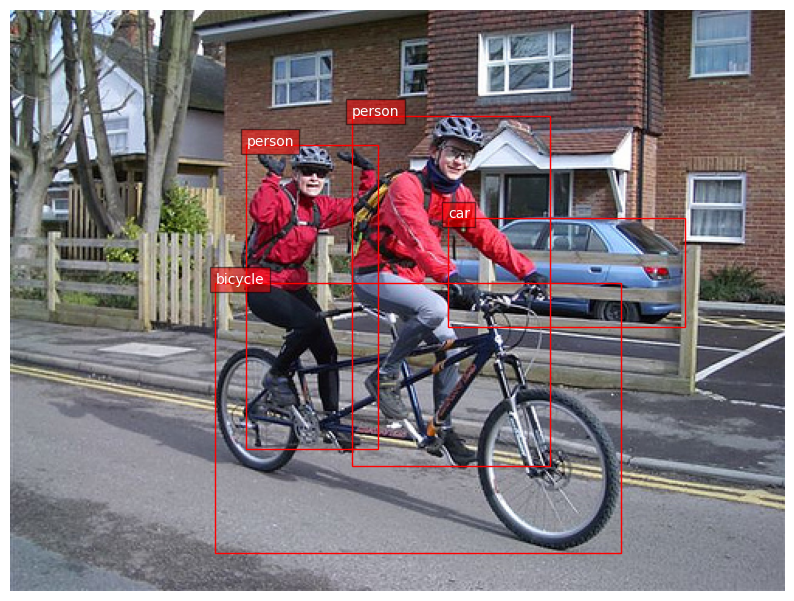

Image shape: torch.Size([3, 375, 500])
Number of objects: 4


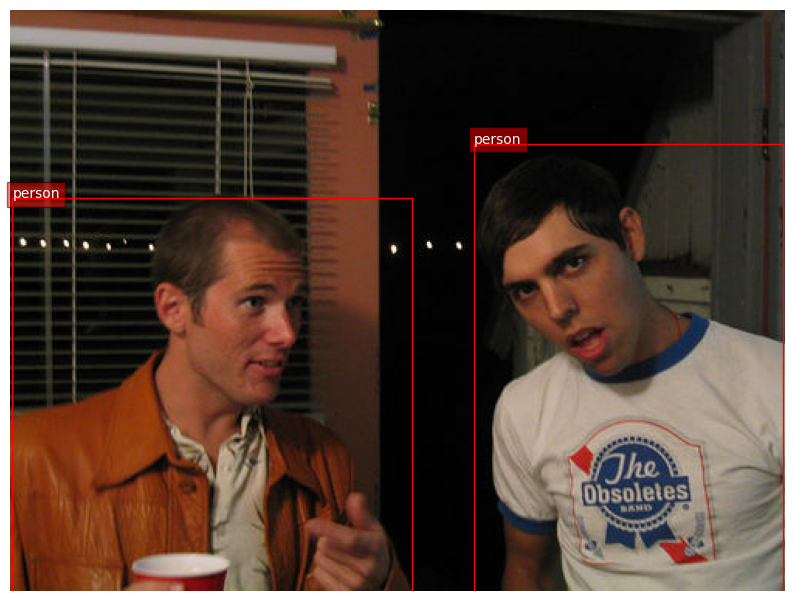

Image shape: torch.Size([3, 375, 500])
Number of objects: 2


In [6]:
def plot_image_with_boxes(img, boxes, labels):
    # Convert tensor to numpy for visualization
    img_np = img.permute(1, 2, 0).numpy().copy()
    
    # Normalize image for display
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img_np)
    
    # Plot each bounding box
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, 
                            edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        # Handle the index correctly based on the label numbering
        class_idx = label.item() - 1  # -1 since class indices are 1-based (0 is background)
        if 0 <= class_idx < len(class_names):
            class_name = class_names[class_idx]
        else:
            class_name = f"Unknown ({label.item()})"
        plt.text(x1, y1, class_name, fontsize=10, 
                color='white', bbox=dict(facecolor='red', alpha=0.5))
    
    plt.axis('off')
    plt.show()

# Visualize a few training samples
try:
    images, targets = next(iter(train_loader))
    for i in range(min(2, len(images))):
        plot_image_with_boxes(images[i], targets[i]['boxes'], targets[i]['labels'])
        print(f"Image shape: {images[i].shape}")
        print(f"Number of objects: {len(targets[i]['boxes'])}")
except Exception as e:
    print(f"Error visualizing samples: {e}")

## 3. Create the Faster R-CNN Model

We'll use a pre-trained Faster R-CNN model with ResNet-50 backbone and Feature Pyramid Network (FPN).

In [7]:
def create_model(num_classes):
    # Load a pre-trained Faster R-CNN model with FPN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
        weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT,
        trainable_backbone_layers=3
    )
    
    # Replace the classifier with a new one for our number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes + 1)  # +1 for background
    
    return model

# Create the model
num_classes = len(class_names)
print(f"Creating model with {num_classes} classes (plus background class)")

try:
    model = create_model(num_classes)
    model.to(device)
    print(f"Model created successfully and moved to {device}")
except Exception as e:
    print(f"Error creating model: {e}")

Creating model with 20 classes (plus background class)
Model created successfully and moved to cuda


## 4. Define Training Functions

Let's define functions for training and evaluation.

In [8]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    n_batches = len(data_loader)
    
    # Use tqdm for a progress bar
    progress_bar = tqdm(data_loader, total=n_batches, desc=f"Training")
    
    for i, (images, targets) in enumerate(progress_bar):
        try:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            # Print individual losses for first batch of each epoch
            if i == 0:  
                print({k: v.item() for k, v in loss_dict.items()})
            
            # Backward pass and optimize
            losses.backward()
            optimizer.step()
            
            # Update statistics
            total_loss += losses.item()
            
            # Update progress bar with current loss
            progress_bar.set_postfix({"batch_loss": f"{losses.item():.4f}", 
                                     "avg_loss": f"{total_loss / (i + 1):.4f}"})
                
        except Exception as e:
            print(f"Error in batch {i}: {e}")
            continue
    
    return total_loss / n_batches

def evaluate(model, data_loader, device):
    model.train()  # Set to train mode to get losses instead of predictions
    total_loss = 0
    n_batches = len(data_loader)
    
    # Use tqdm for a progress bar
    progress_bar = tqdm(data_loader, total=n_batches, desc=f"Evaluating")
    
    with torch.no_grad():
        for i, (images, targets) in enumerate(progress_bar):
            try:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                
                # Forward pass - keeping model in train mode to get losses
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                
                total_loss += losses.item()
                
                # Update progress bar
                progress_bar.set_postfix({"val_loss": f"{losses.item():.4f}"})
                
            except Exception as e:
                print(f"Error during evaluation batch {i}: {e}")
                continue
    
    return total_loss / n_batches

## 5. Train the Model

Now let's train the model for a few epochs.

In [9]:
# Training parameters
num_epochs = 10
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# For saving the best model
best_val_loss = float('inf')
best_model_path = 'best_pascal_voc_model.pth'

# Training loop
print("Starting training...")
start_time = time.time()

# Dictionary to store training history
history = {
    'train_loss': [],
    'val_loss': [],
    'epochs': []
}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train for one epoch
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    
    # Update the learning rate
    lr_scheduler.step()
    
    # Evaluate on the validation set
    val_loss = evaluate(model, val_loader, device)
    
    # Update history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['epochs'].append(epoch + 1)
    
    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved new best model with validation loss: {val_loss:.4f}")
        
    # Save checkpoint for each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
    }, f'checkpoint_epoch_{epoch+1}.pth')

total_time = time.time() - start_time
print(f"Training complete in {total_time // 60:.0f}m {total_time % 60:.0f}s")
print(f"Best validation loss: {best_val_loss:.4f}")

Starting training...

Epoch 1/10


Training:   0%|          | 0/375 [00:00<?, ?it/s]

{'loss_classifier': 2.9920458793640137, 'loss_box_reg': 0.4281904697418213, 'loss_objectness': 0.007436675950884819, 'loss_rpn_box_reg': 0.016193732619285583}


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 0.4887, Val Loss: 0.4080
Saved new best model with validation loss: 0.4080

Epoch 2/10


Training:   0%|          | 0/375 [00:00<?, ?it/s]

{'loss_classifier': 0.10912767052650452, 'loss_box_reg': 0.0778539851307869, 'loss_objectness': 0.003765734378248453, 'loss_rpn_box_reg': 0.017596779391169548}


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 0.3080, Val Loss: 0.3841
Saved new best model with validation loss: 0.3841

Epoch 3/10


Training:   0%|          | 0/375 [00:00<?, ?it/s]

{'loss_classifier': 0.14012102782726288, 'loss_box_reg': 0.1849324107170105, 'loss_objectness': 0.009624781087040901, 'loss_rpn_box_reg': 0.008288973942399025}


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 0.2474, Val Loss: 0.3625
Saved new best model with validation loss: 0.3625

Epoch 4/10


Training:   0%|          | 0/375 [00:00<?, ?it/s]

{'loss_classifier': 0.08752874284982681, 'loss_box_reg': 0.15368053317070007, 'loss_objectness': 0.0036663878709077835, 'loss_rpn_box_reg': 0.03838696330785751}


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 0.1784, Val Loss: 0.3499
Saved new best model with validation loss: 0.3499

Epoch 5/10


Training:   0%|          | 0/375 [00:00<?, ?it/s]

{'loss_classifier': 0.022884609177708626, 'loss_box_reg': 0.0434953048825264, 'loss_objectness': 0.004135517869144678, 'loss_rpn_box_reg': 0.010731813497841358}


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 0.1614, Val Loss: 0.3626

Epoch 6/10


Training:   0%|          | 0/375 [00:00<?, ?it/s]

{'loss_classifier': 0.06633834540843964, 'loss_box_reg': 0.09593172371387482, 'loss_objectness': 0.010260538198053837, 'loss_rpn_box_reg': 0.03426305577158928}


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 6/10 - Train Loss: 0.1538, Val Loss: 0.3682

Epoch 7/10


Training:   0%|          | 0/375 [00:00<?, ?it/s]

{'loss_classifier': 0.026590922847390175, 'loss_box_reg': 0.05167179927229881, 'loss_objectness': 0.0012451456859707832, 'loss_rpn_box_reg': 0.022633859887719154}


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 7/10 - Train Loss: 0.1461, Val Loss: 0.3706

Epoch 8/10


Training:   0%|          | 0/375 [00:00<?, ?it/s]

{'loss_classifier': 0.04898704215884209, 'loss_box_reg': 0.05239638686180115, 'loss_objectness': 0.0033358274959027767, 'loss_rpn_box_reg': 0.0042024049907922745}


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 8/10 - Train Loss: 0.1449, Val Loss: 0.3714

Epoch 9/10


Training:   0%|          | 0/375 [00:00<?, ?it/s]

{'loss_classifier': 0.03043152019381523, 'loss_box_reg': 0.04982827231287956, 'loss_objectness': 0.00495338486507535, 'loss_rpn_box_reg': 0.003420960856601596}


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 9/10 - Train Loss: 0.1435, Val Loss: 0.3718

Epoch 10/10


Training:   0%|          | 0/375 [00:00<?, ?it/s]

{'loss_classifier': 0.05888788029551506, 'loss_box_reg': 0.10905364155769348, 'loss_objectness': 0.00014958485553506762, 'loss_rpn_box_reg': 0.005483532324433327}


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 10/10 - Train Loss: 0.1433, Val Loss: 0.3711
Training complete in 27m 14s
Best validation loss: 0.3499


## 6. Visualize Training Progress

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history['epochs'], history['train_loss'], 'b-', label='Training Loss')
plt.plot(history['epochs'], history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 7. Evaluate the Model on Test Images

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24020\863125288.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


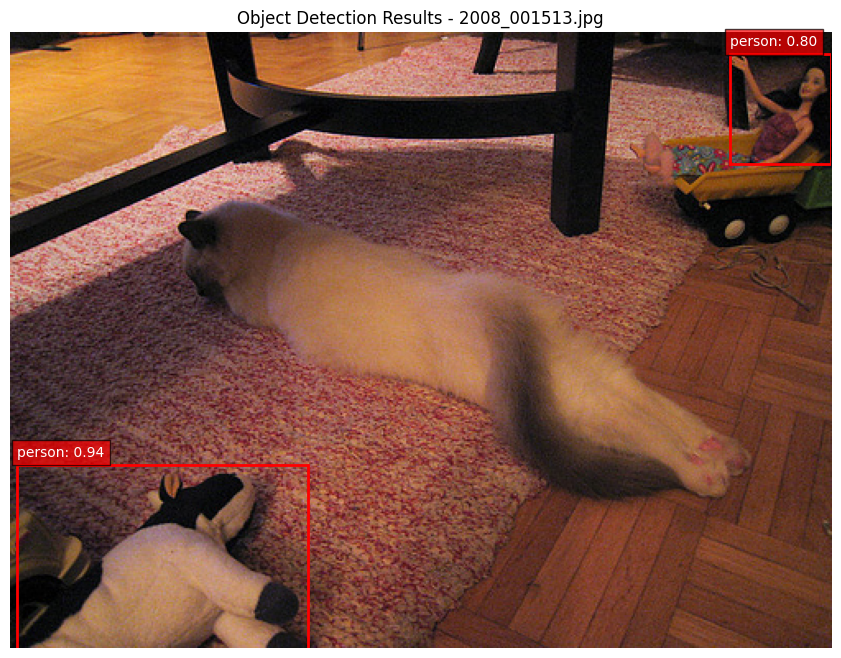

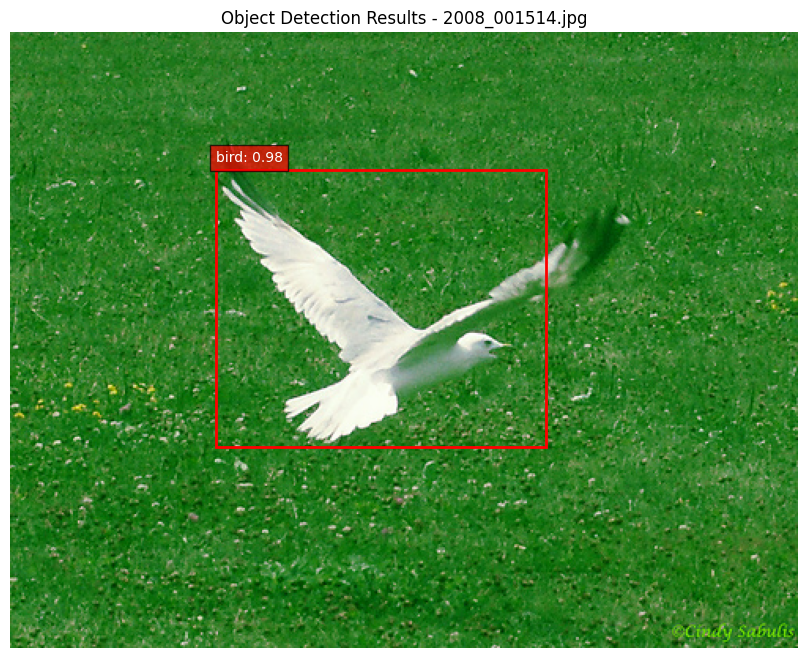

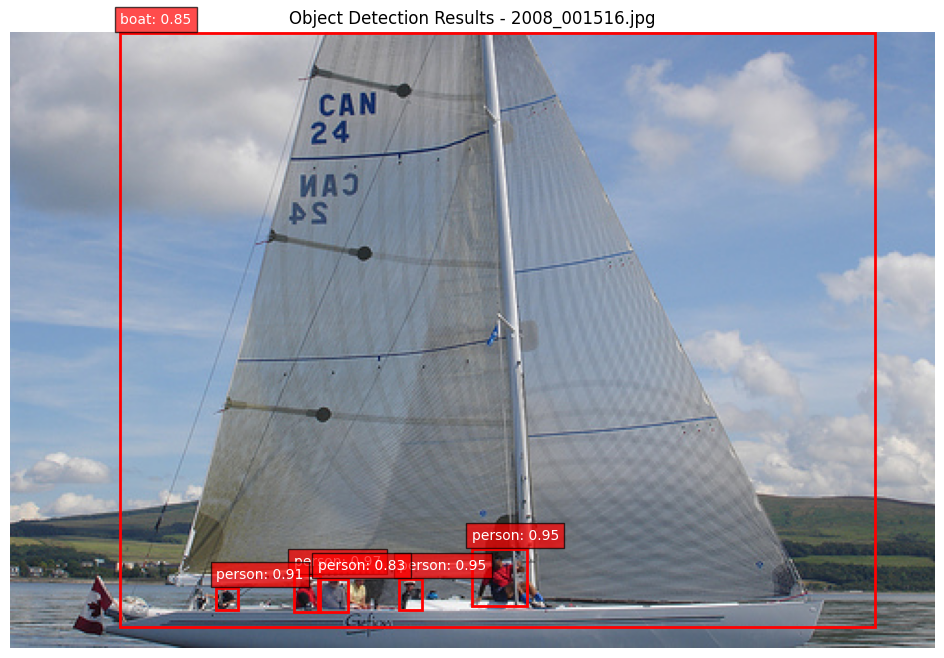

In [11]:
# Load the best model for inference
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()  # Set to evaluation mode

def predict_and_visualize(image_path, threshold=0.5):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_image = image.copy()
    
    # Transform the image to tensor
    transform = transforms.Compose([transforms.ToTensor()])
    image = transform(image)
    
    # Move image to device and run prediction
    image = image.to(device)
    with torch.no_grad():
        prediction = model([image])[0]
    
    # Get boxes, labels, and scores above threshold
    boxes = prediction['boxes'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    
    # Filter predictions based on threshold
    mask = scores >= threshold
    boxes = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    
    # Visualize results
    plt.figure(figsize=(12, 8))
    plt.imshow(orig_image)
    
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box.astype(int)
        class_name = class_names[label-1]  # -1 because classes start from 1 (0 is background)
        
        # Create a rectangle
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, 
                           edgecolor='red', facecolor='none')
        plt.gca().add_patch(rect)
        
        # Add label with confidence score
        plt.text(x1, y1-5, f"{class_name}: {score:.2f}", 
                 fontsize=10, color='white',
                 bbox=dict(facecolor='red', alpha=0.7))
    
    plt.axis('off')
    plt.title(f'Object Detection Results - {os.path.basename(image_path)}')
    plt.show()

# Test the model on a few validation images
try:
    # Get a few images from validation set
    test_image_paths = [os.path.join(val_img_dir, val_dataset.unique_images[i]) for i in range(3)]
    
    for image_path in test_image_paths:
        predict_and_visualize(image_path, threshold=0.7)
except Exception as e:
    print(f"Error during prediction: {e}")

In [12]:
## 8. Calculate Mean Average Precision (mAP)

#Let's evaluate the model using the Mean Average Precision metric, which is standard for object detection.

In [ ]:
# Downgrade to a stable NumPy version that has the char module
!pip install numpy==1.26.4 --force-reinstall

In [ ]:
# Check if NumPy is working correctly after the upgrade
import numpy as np
print(f"NumPy version: {np.__version__}")

# Try importing numpy.char explicitly
try:
    from numpy import char
    print("✓ numpy.char module is available")
except ImportError as e:
    print(f"✗ Error importing numpy.char: {e}")

In [ ]:
# First, install required packages
!pip install torchmetrics
!pip install "torchmetrics[detection]"

# Check if we have the required variables
import torch

# Check for required variables
required_vars = ['model', 'val_loader', 'device', 'class_names']
missing_vars = [var for var in required_vars if var not in locals() and var not in globals()]

if missing_vars:
    print(f"⚠️ Missing variables: {missing_vars}")
    print("Please run the earlier cells in the notebook that define these variables before running this cell.")
    # Try to recover with some defaults if possible
    if 'device' in missing_vars:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Created default device: {device}")
        missing_vars.remove('device')
    
    if missing_vars:  # If we still have missing variables
        print("Cannot continue with mAP calculation until all required variables are defined.")
        import sys
        sys.exit(0)  # Exit the cell execution

# Now proceed with the dependencies check and mAP calculation
print("\n## Calculating Mean Average Precision (mAP)")

try:
    import torchmetrics.detection
    import pycocotools
    print("✓ All required dependencies are installed.")
    has_dependencies = True
except ImportError as e:
    print(f"⚠️ Missing dependency: {e}")
    print("Please ensure all dependencies are installed by running the commands above.")
    has_dependencies = False

# Only run mAP calculation if dependencies are available
if has_dependencies:
    def calculate_map(model, data_loader, device):
        model.eval()  # Set model to evaluation mode
        metric = torchmetrics.detection.MeanAveragePrecision()
        
        from tqdm.notebook import tqdm
        with torch.no_grad():
            for images, targets in tqdm(data_loader, desc="Calculating mAP"):
                images = list(img.to(device) for img in images)
                
                # Get model predictions
                preds = model(images)
                
                # Move targets and predictions to CPU for metric calculation
                targets = [{k: v.cpu() for k, v in t.items()} for t in targets]
                preds = [{k: v.cpu() for k, v in p.items()} for p in preds]
                
                # Update metrics
                metric.update(preds, targets)
        
        # Compute final metrics
        result = metric.compute()
        return result

    try:
        # Calculate mAP on validation set
        print("Calculating Mean Average Precision on validation set...")
        map_results = calculate_map(model, val_loader, device)
        print(f"Mean Average Precision (mAP @ IoU=0.50:0.95): {map_results['map']:.4f}")
        print(f"Mean Average Precision (mAP @ IoU=0.50): {map_results['map_50']:.4f}")
        print(f"Mean Average Precision (mAP @ IoU=0.75): {map_results['map_75']:.4f}")
        
        # Print per-class metrics if available
        if 'map_per_class' in map_results and 'class_names' in globals():
            print("\nPer-Class Mean Average Precision:")
            for i, class_map in enumerate(map_results['map_per_class']):
                if i < len(class_names):
                    print(f"  {class_names[i]}: {class_map:.4f}")
    except Exception as e:
        print(f"Error calculating mAP: {e}")
        import traceback
        traceback.print_exc()
else:
    print("\nSkipping mAP calculation due to missing dependencies.")

## 9. Export and Save the Model

Finally, let's save the model for future use.

In [ ]:
# Save the final model state dict
torch.save(model.state_dict(), 'pascal_voc_fasterrcnn_final.pth')
print("Model saved successfully as 'pascal_voc_fasterrcnn_final.pth'")

# Save class names for future inference
import json
with open('pascal_voc_classes.json', 'w') as f:
    json.dump(class_names, f)
print("Class names saved as 'pascal_voc_classes.json'")

## 10. Conclusion

In this notebook, we've:

1. Set up a dataset for Pascal VOC object detection
2. Created a Faster R-CNN model with ResNet-50 backbone and FPN
3. Trained the model for object detection
4. Evaluated the model using Mean Average Precision
5. Visualized detection results
6. Exported the model for future use

The model can be further improved with:
- More training epochs
- Data augmentation techniques
- Hyperparameter tuning
- Different backbone architectures
- Ensemble methods